# Turbofan Engine Degradation Prediction (End-to-End Project)

## Objective
Predict the Remaining Useful Life (RUL) of turbofan engines based on sensor data. The goal is to predict how many more operational cycles an engine has before it fails.

## Datasets
The project uses the NASA C-MAPSS Turbofan Degradation dataset, which consists of four sub-datasets:
- **FD001**: HPC Degradation, Sea Level (1 condition), 1 Fault Mode.
- **FD002**: HPC Degradation, 6 Operating Conditions, 1 Fault Mode.
- **FD003**: HPC & Fan Degradation, Sea Level, 2 Fault Modes.
- **FD004**: HPC & Fan Degradation, 6 Operating Conditions, 2 Fault Modes.

## Approach
1. **Data Loading**: Load train, test, and RUL files.
2. **EDA**: Analyze sensor trends and correlations.
3. **Preprocessing**: Calculate RUL, normalize data, and generate time-series sequences.
4. **Modeling**: Train Deep Learning models (LSTM, GRU, CNN-LSTM, etc.).
5. **Evaluation**: Compare models using RMSE and the NASA Scoring function.

In [1]:
import os
import json
import joblib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
    GlobalAveragePooling1D, Bidirectional, Attention, LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Plot settings
plt.style.use('ggplot')
sns.set_palette("husl")

In [2]:
# --------------------------
# Configuration
# --------------------------
# Use current directory for data
DATA_DIR = "."
OUT_DIR = "outputs"
MODELS_DIR = "models"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Datasets to process
DATASETS = ["FD001", "FD002", "FD003", "FD004"]

# Hyperparameters
SEQ_LEN = 50          # Window size
RUL_CAP = 125         # Cap RUL values (Piecewise Linear RUL)
BATCH_SIZE = 128
EPOCHS = 30           # Reduced for demonstration speed, increase for better performance
PATIENCE = 5          # Early stopping patience

## 1. Data Loading & Utility Functions

In [3]:
def load_cmapss_data(dataset_name: str, data_dir: str) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
    """Loads train, test, and RUL files for a specific dataset."""
    print(f"Loading {dataset_name}...")
    
    # Define columns
    cols = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
    
    # Load Train
    train_path = os.path.join(data_dir, f"train_{dataset_name}.txt")
    train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=cols)
    
    # Load Test
    test_path = os.path.join(data_dir, f"test_{dataset_name}.txt")
    test_df = pd.read_csv(test_path, sep=r"\s+", header=None, names=cols)
    
    # Load RUL (True RUL for test data)
    rul_path = os.path.join(data_dir, f"RUL_{dataset_name}.txt")
    rul_df = pd.read_csv(rul_path, sep=r"\s+", header=None, names=["RUL"])
    rul_vector = rul_df["RUL"].values
    
    return train_df, test_df, rul_vector

def calculate_rul(df: pd.DataFrame, cap: int = None) -> pd.DataFrame:
    """Calculates RUL for training data: max_cycle - current_cycle."""
    max_cycle = df.groupby("unit")["cycle"].transform("max")
    df["RUL"] = max_cycle - df["cycle"]
    if cap:
        df["RUL"] = df["RUL"].clip(upper=cap)
    return df

def get_valid_sensors(df: pd.DataFrame) -> List[str]:
    """Returns sensor columns that are not constant (std > 0)."""
    sensor_cols = [c for c in df.columns if c.startswith("s")]
    return [c for c in sensor_cols if df[c].std() > 0.01]  # Threshold to remove near-constant

## 2. Exploratory Data Analysis (EDA)
We visualize sensor readings for a sample engine to understand degradation patterns.

Loading FD001...
FD001 Valid Sensors: 14
Plotting sensor trends for Unit 1 in FD001...


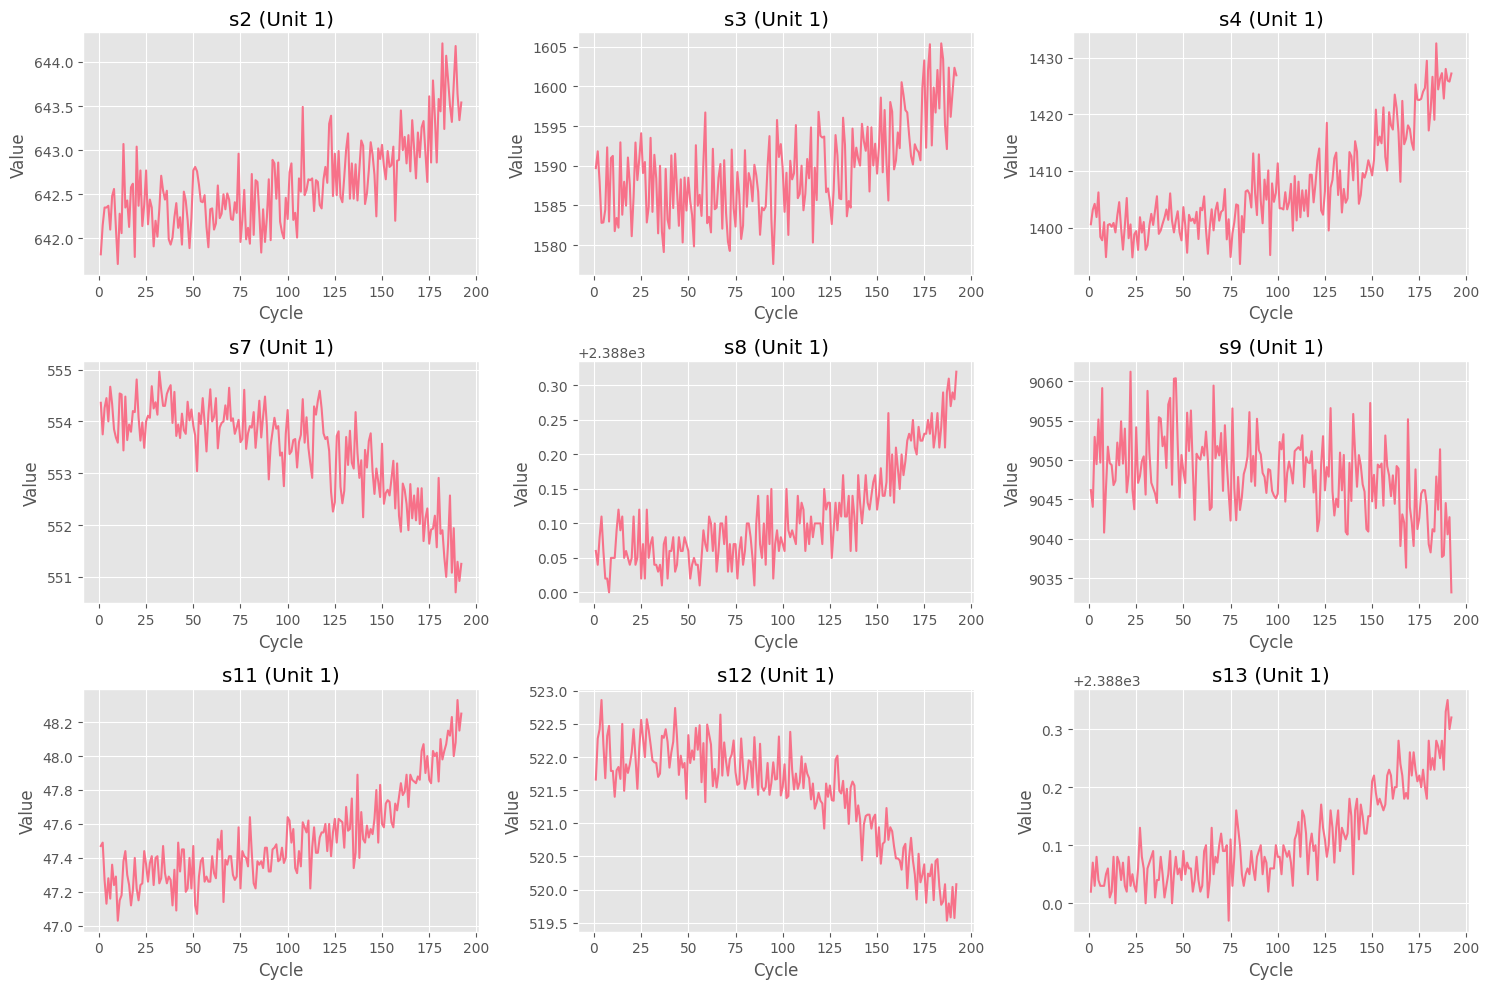

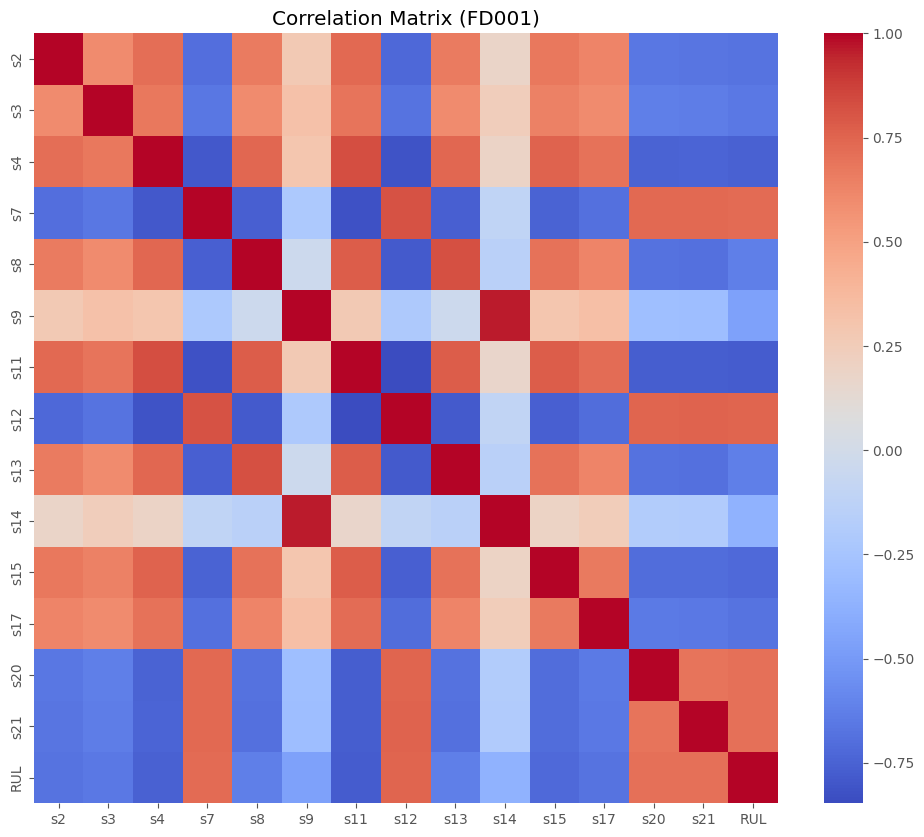

In [4]:
def plot_sensor_trends(df: pd.DataFrame, unit_id: int, sensors: List[str]):
    """Plots sensor readings for a specific engine unit."""
    subset = df[df["unit"] == unit_id]
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors[:9]):  # Plot first 9 sensors
        plt.subplot(3, 3, i + 1)
        plt.plot(subset["cycle"], subset[sensor])
        plt.title(f"{sensor} (Unit {unit_id})")
        plt.xlabel("Cycle")
        plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

# Example EDA on FD001
try:
    train_fd001, _, _ = load_cmapss_data("FD001", DATA_DIR)
    train_fd001 = calculate_rul(train_fd001, cap=RUL_CAP)
    valid_sensors_fd001 = get_valid_sensors(train_fd001)
    
    print(f"FD001 Valid Sensors: {len(valid_sensors_fd001)}")
    print("Plotting sensor trends for Unit 1 in FD001...")
    plot_sensor_trends(train_fd001, unit_id=1, sensors=valid_sensors_fd001)
    
    # Correlation Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(train_fd001[valid_sensors_fd001 + ['RUL']].corr(), annot=False, cmap="coolwarm")
    plt.title("Correlation Matrix (FD001)")
    plt.show()
except FileNotFoundError:
    print("FD001 files not found. Skipping EDA.")

## 3. Preprocessing
- **Scaling**: Normalize sensor data to [0, 1] range.
- **Sequence Generation**: Create sliding windows (samples, seq_len, features) for LSTM/GRU input.

In [5]:
def gen_sequence(df: pd.DataFrame, seq_len: int, cols: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    """Generates sequences for training (X) and targets (y)."""
    data_array = df[cols].values
    num_elements = data_array.shape[0]
    
    # Iterate and create sequences
    # We iterate such that we have at least seq_len data points
    # For training, we can use all possible windows
    X = []
    y = []
    
    # We need to group by unit to avoid crossing engine boundaries
    for unit_id, group in df.groupby("unit"):
        group_data = group[cols].values
        group_rul = group["RUL"].values
        
        for start, stop in zip(range(0, len(group_data) - seq_len), range(seq_len, len(group_data))):
            X.append(group_data[start:stop, :])
            y.append(group_rul[stop])
            
    return np.array(X), np.array(y)

def gen_test_sequence(df: pd.DataFrame, seq_len: int, cols: List[str]) -> Tuple[np.ndarray, List[int]]:
    """Generates the LAST sequence for each engine in the test set."""
    X = []
    unit_ids = []
    
    for unit_id, group in df.groupby("unit"):
        data = group[cols].values
        if len(data) >= seq_len:
            X.append(data[-seq_len:])
            unit_ids.append(unit_id)
        else:
            # Padding if sequence is too short (rare but possible)
            pad = np.repeat(data[0:1, :], seq_len - len(data), axis=0)
            X.append(np.vstack([pad, data]))
            unit_ids.append(unit_id)
            
    return np.array(X), unit_ids

## 4. Model Definitions
We define multiple architectures to compare performance.

In [6]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        GRU(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

## 5. Training & Evaluation Loop
We iterate through each dataset, train models, and evaluate them.

In [7]:
def nasa_scoring_function(y_true, y_pred):
    """Asymmetric scoring function from the competition."""
    diff = y_pred - y_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

results = []

for fd in DATASETS:
    print(f"\n{'='*40}\nProcessing {fd}\n{'='*40}")
    
    try:
        # 1. Load Data
        train_df, test_df, rul_true = load_cmapss_data(fd, DATA_DIR)
        
        # 2. Preprocessing
        # Calculate RUL for train
        train_df = calculate_rul(train_df, cap=RUL_CAP)
        
        # Select sensors
        sensors = get_valid_sensors(train_df)
        print(f"Selected {len(sensors)} sensors: {sensors}")
        
        # Scale Data
        scaler = MinMaxScaler()
        # Fit on train, transform train & test
        train_df[sensors] = scaler.fit_transform(train_df[sensors])
        test_df[sensors] = scaler.transform(test_df[sensors])
        
        # Save scaler for app usage
        joblib.dump(scaler, os.path.join(MODELS_DIR, f"scaler_{fd}.pkl"))
        
        # Generate Sequences
        X_train, y_train = gen_sequence(train_df, SEQ_LEN, sensors)
        X_test, _ = gen_test_sequence(test_df, SEQ_LEN, sensors)
        
        print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        
        # 3. Train & Evaluate Models
        model_builders = {
            "LSTM": build_lstm_model,
            "GRU": build_gru_model,
            "CNN-LSTM": build_cnn_lstm_model
        }
        
        for model_name, builder in model_builders.items():
            print(f"\nTraining {model_name} on {fd}...")
            
            model = builder((SEQ_LEN, len(sensors)))
            
            es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
            
            history = model.fit(
                X_train, y_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_split=0.2,
                callbacks=[es],
                verbose=0  # Silent training for cleaner output
            )
            
            # Predict
            y_pred = model.predict(X_test).flatten()
            
            # Metrics
            rmse = np.sqrt(mean_squared_error(rul_true, y_pred))
            mae = mean_absolute_error(rul_true, y_pred)
            nasa_score = nasa_scoring_function(rul_true, y_pred)
            
            print(f"{model_name} Results -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, NASA Score: {nasa_score:.2f}")
            
            results.append({
                "Dataset": fd,
                "Model": model_name,
                "RMSE": rmse,
                "MAE": mae,
                "NASA Score": nasa_score
            })
            
            # Save best model
            model.save(os.path.join(MODELS_DIR, f"model_{fd}_{model_name}.h5"))
            
    except FileNotFoundError as e:
        print(f"Skipping {fd}: {e}")
    except Exception as e:
        print(f"Error processing {fd}: {e}")


Processing FD001
Loading FD001...
Selected 14 sensors: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
Error processing FD001: could not convert string to float: 's2'

Processing FD002
Loading FD002...
Selected 20 sensors: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's17', 's18', 's19', 's20', 's21']
Train shape: (40759, 50, 20), Test shape: (259, 50, 20)

Training LSTM on FD002...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


LSTM Results -> RMSE: 54.20, MAE: 45.59, NASA Score: 134494.47

Training GRU on FD002...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


GRU Results -> RMSE: 29.05, MAE: 19.84, NASA Score: 11888.85

Training CNN-LSTM on FD002...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


CNN-LSTM Results -> RMSE: 54.19, MAE: 45.59, NASA Score: 134402.64

Processing FD003
Loading FD003...
Selected 15 sensors: ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
Train shape: (19720, 50, 15), Test shape: (100, 50, 15)

Training LSTM on FD003...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


LSTM Results -> RMSE: 42.59, MAE: 36.27, NASA Score: 27217.31

Training GRU on FD003...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step WARNING:tensorflow:6 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EC034CE520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


GRU Results -> RMSE: 14.30, MAE: 10.62, NASA Score: 284.70

Training CNN-LSTM on FD003...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


CNN-LSTM Results -> RMSE: 18.01, MAE: 13.11, NASA Score: 882.74

Processing FD004
Loading FD004...
Selected 20 sensors: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's17', 's18', 's19', 's20', 's21']
Train shape: (48799, 50, 20), Test shape: (248, 50, 20)

Training LSTM on FD004...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


LSTM Results -> RMSE: 54.57, MAE: 46.56, NASA Score: 118909.59

Training GRU on FD004...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


GRU Results -> RMSE: 28.61, MAE: 20.98, NASA Score: 6375.38

Training CNN-LSTM on FD004...


c:\Users\harendra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


CNN-LSTM Results -> RMSE: 30.42, MAE: 22.86, NASA Score: 9103.26


## 6. Results Summary

  Dataset     Model       RMSE        MAE     NASA Score
1   FD002       GRU  29.046797  19.841789   11888.848863
2   FD002  CNN-LSTM  54.194051  45.588207  134402.639114
0   FD002      LSTM  54.198540  45.592957  134494.470703
4   FD003       GRU  14.303466  10.620867     284.701616
5   FD003  CNN-LSTM  18.005288  13.111852     882.739969
3   FD003      LSTM  42.588988  36.273136   27217.313903
7   FD004       GRU  28.614729  20.976994    6375.381303
8   FD004  CNN-LSTM  30.419801  22.861410    9103.259063
6   FD004      LSTM  54.574781  46.559177  118909.590282


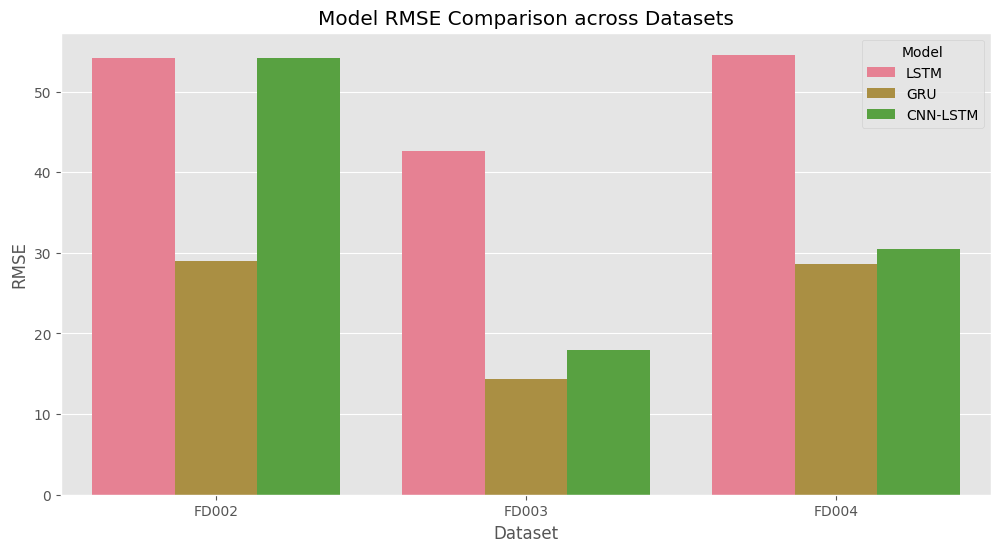

In [8]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    print(results_df.sort_values(["Dataset", "RMSE"]))
    
    # Plot RMSE comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x="Dataset", y="RMSE", hue="Model")
    plt.title("Model RMSE Comparison across Datasets")
    plt.show()
else:
    print("No results generated.")